In [1]:
# import 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

### Load Models

In [2]:
# infer_RHNH = keras.models.load_model('../../Weights/helmet_no_helmet_512')
infer_RHNH = keras.models.load_model('../../Weights/helmet_no_helmet_ROI')
infer_rider_motor = keras.models.load_model('../../Weights/rider_motor_512')


### Load Image / Frame

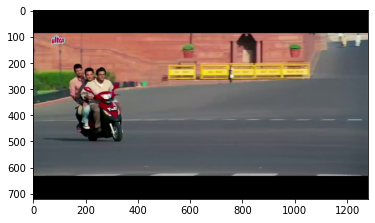

In [3]:
# # VIDEO

# read video
cap = cv2.VideoCapture('../../data/Videos/3idiots.mp4')

# read first frame
ret, frame = cap.read()
frame2 = frame.copy()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# # read image
# frame = cv2.imread('../../data/testing_data_310Images/final_test_set/idd_temporal_test_1_00083_496299_leftImg8bit_0003233.jpeg')
# frame2 = cv2.imread('../../data/testing_data_310Images/final_test_set/idd_temporal_test_1_00083_496299_leftImg8bit_0003233.jpeg')
# # convert to rgb
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# display the first frame
plt.imshow(frame)
plt.show()


In [4]:
input_size = 512
frame_size = frame.shape[:2]
image_data = cv2.resize(frame, (input_size, input_size))
image_data = image_data / 255.
image_data = image_data[np.newaxis, ...].astype(np.float32)

batch_data = tf.constant(image_data)

In [5]:
rider_motor_bbox = infer_rider_motor.predict(batch_data)

1/1 [==============================] - 34s 34s/step


In [6]:
iou = 0.45
score = 0.50

for value in rider_motor_bbox:
    temp_value = np.expand_dims(value, axis=0)
    boxes_R_M = temp_value[:, :, 0:4]
    pred_conf = temp_value[:, :, 4:]

boxes_R_M, scores_R_M, classes_R_M, valid_detections_R_M = tf.image.combined_non_max_suppression(
            boxes=tf.reshape(boxes_R_M, (tf.shape(boxes_R_M)[0], -1, 1, 4)),
            scores=tf.reshape(
                pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=iou,
            score_threshold=score
        )
num_objects_R_M = valid_detections_R_M.numpy()[0]
boxes_R_M = boxes_R_M.numpy()[0]
boxes_R_M = boxes_R_M[0:int(num_objects_R_M)]
scores_R_M = scores_R_M.numpy()[0]
scores_R_M = scores_R_M[0:int(num_objects_R_M)]
classes_R_M = classes_R_M.numpy()[0]
classes_R_M = classes_R_M[0:int(num_objects_R_M)]

deleted_indx = []
allowed_classes = [0,1]
for i in range(num_objects_R_M):
    class_indx = int(classes_R_M[i])
    if class_indx not in allowed_classes:
        deleted_indx.append(i)
boxes_R_M = np.delete(boxes_R_M, deleted_indx, axis=0)
scores_R_M = np.delete(scores_R_M, deleted_indx, axis=0)
classes_R_M = np.delete(classes_R_M, deleted_indx, axis=0)
num_objects_R_M = len(classes_R_M)

# MOTORCYCLE CLASS CHANGED TO 3 FROM 1
classes_R_M[classes_R_M == 1] = 3

print("Allowed classes_R_M (RM)")
print(classes_R_M)

print(boxes_R_M.shape)
print(classes_R_M)

print("RM boxes")
print(boxes_R_M)

Allowed classes_R_M (RM)
[3. 0. 0.]
(3, 4)
[3. 0. 0.]
RM boxes
[[0.4020506  0.13151684 0.7032441  0.28226325]
 [0.31009793 0.16385458 0.6497237  0.25417086]
 [0.30653036 0.11679484 0.64331484 0.19953595]]


In [7]:
import pandas as pd

# Getting the rider motorcycle dataframe 

# Bounding boxes are in normalized ymin, xmin, ymax, xmax
original_h, original_w, _ = frame.shape

#getting rider, motorcycle dataframe
df = pd.DataFrame(classes_R_M, columns=['class_id'])
ymin = boxes_R_M[:, 0]
xmin = boxes_R_M[:, 1]
ymax = boxes_R_M[:, 2]
xmax = boxes_R_M[:, 3]
df['x'] = pd.DataFrame(xmin + (xmax-xmin)/2, columns=['x'])
df['y'] = pd.DataFrame(ymin + (ymax-ymin)/2, columns=['y'])
df['w'] = pd.DataFrame(xmax-xmin, columns=['w'])
df['h'] = pd.DataFrame(ymax-ymin, columns=['h'])
rider = df.loc[df['class_id']==0]
motorcycle = df.loc[df['class_id']==3]

print(rider)
print(motorcycle)

   class_id         x         y         w         h
1       0.0  0.209013  0.479911  0.090316  0.339626
2       0.0  0.158165  0.474923  0.082741  0.336784
   class_id        x         y         w         h
0       3.0  0.20689  0.552647  0.150746  0.301193


In [8]:
# assign instance id to each rider AND motorcycle
import sys
sys.path.append('../')
from core.association import motor_rider_iou, motor2_rider_iou

def get_instance(rider, motorcycle, iou_threshold):
    """
    args:
    rider, motorcycle : pd.DataFrame

    output:
    rider, motorycle : pd.DataFrame with a column named 'instance_id'
    """
    rider['instance_id'] = -1
    motorcycle['instance_id'] = -1
    
    for i in range(len(motorcycle)):
        motorcycle.iat[i,motorcycle.columns.get_loc('instance_id')] = i
        for j in range(len(rider)):
            if (motor_rider_iou(motorcycle.iloc[i], rider.iloc[j]) > iou_threshold):
                if (rider.iloc[j]['instance_id'] == -1):
                    rider.iat[j,rider.columns.get_loc('instance_id')] = i
                else:
                    instance = int(rider.iloc[j]['instance_id'])
                    instance_final = motor2_rider_iou(motorcycle.iloc[i], motorcycle.iloc[instance], rider.iloc[j], i, instance)
                    rider.iat[j,rider.columns.get_loc('instance_id')] = instance_final
    return rider, motorcycle

rider, motorcycle = get_instance(rider, motorcycle, 0.01)
print(rider)
print(motorcycle)


   class_id         x         y         w         h  instance_id
1       0.0  0.209013  0.479911  0.090316  0.339626            0
2       0.0  0.158165  0.474923  0.082741  0.336784            0
   class_id        x         y         w         h  instance_id
0       3.0  0.20689  0.552647  0.150746  0.301193            0


C:\Users\basur\AppData\Local\Temp\ipykernel_11632\4082315931.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider['instance_id'] = -1
C:\Users\basur\AppData\Local\Temp\ipykernel_11632\4082315931.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motorcycle['instance_id'] = -1


<class 'pandas.core.series.Series'>
0    0.282263
dtype: float32
<class 'float'>
(206, 138, 520, 371)


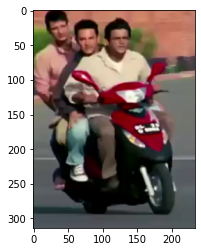

In [9]:
def extract_roi(frame, rider, motorcycle) :
    """
    args:
    frame : np.array
    rider, motorcycle : pd.DataFrame

    output:
    roi_instances : list of np.array
    """
    roi_instances = []
    for i in range(len(motorcycle)):
        motor = motorcycle.loc[motorcycle['instance_id']==i]
        instance = motorcycle.iloc[i]['instance_id']
        ride = rider.loc[rider['instance_id']== instance]

        if (len(ride)==0):
            continue
        
        print(type(motor['x'] + motor['w']/2))
        print(motor['x'] + motor['w']/2)
        print(type(max(ride['x'] + ride['w']/2)))
        xmax = max(float(motor['x'] + motor['w']/2), max(ride['x'] + ride['w']/2))
        xmin = min(float(motor['x'] - motor['w']/2), min(ride['x'] - ride['w']/2))
        ymax = max(float(motor['y'] + motor['h']/2), max(ride['y'] + ride['h']/2))
        ymin = min(float(motor['y'] - motor['h']/2), min(ride['y'] - ride['h']/2))

        w = xmax - xmin
        h = ymax - ymin

        xmax = xmax + 0.05*w
        xmin = xmin - 0.05*w

        ymax = ymax + 0.05 * h
        ymin = ymin - 0.05 * h

        if (xmin < 0):
            xmin=0
        if (xmax >1):
            xmax=1
        if (ymax>1):
            ymax =1
        if(ymin<0):
            ymin =0

        t = int(ymin*frame.shape[0])
        l = int(xmin*frame.shape[1])
        b = int(ymax*frame.shape[0])
        r = int(xmax*frame.shape[1])

        if t<0 or l<0 or b<0 or r<0:
            continue
        roi_frame = frame[t:b, l:r]
        # roi_frame = frame
        original_position = (t,l,b,r)
        roi_dict = {'frame':roi_frame, 'original_position':original_position}
        roi_instances.append(roi_dict)

    return roi_instances

roi_instances = extract_roi(frame, rider, motorcycle)

# display the cropped images
for i in range(len(roi_instances)):
    plt.imshow(roi_instances[i]['frame'])
    print(roi_instances[i]['original_position'])
    plt.show()


In [10]:
input_size = 512
all_batch_data = []
frame_size_ROI = []
for i in range(len(roi_instances)):
    instance_frame = roi_instances[i]['frame']
    frame_size_ROI.append(instance_frame.shape)
    image_data = cv2.resize(instance_frame, (input_size, input_size))
    image_data = image_data / 255.
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    batch_data = tf.constant(image_data)
    all_batch_data.append(batch_data)

print(frame_size_ROI)

[(314, 233, 3)]


In [11]:
all_instance_H_NH_boxes = []

for i in range(len(all_batch_data)):
    batch_data = all_batch_data[i]
    H_NH_boxes = infer_RHNH.predict(batch_data)
    all_instance_H_NH_boxes.append(H_NH_boxes)

1/1 [==============================] - 34s 34s/step


In [12]:
# # plot rider and motorcycle bounding boxes

# for motor in motorcycle.iterrows():
#     xmin = motor[1]['x'] - motor[1]['w']/2
#     ymin = motor[1]['y'] - motor[1]['h']/2
#     xmax = motor[1]['x'] + motor[1]['w']/2
#     ymax = motor[1]['y'] + motor[1]['h']/2
#     xmin = int(xmin*original_w)
#     ymin = int(ymin*original_h)
#     xmax = int(xmax*original_w)
#     ymax = int(ymax*original_h)
#     cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0,0,255), 5)
#     cv2.putText(frame, 'motorcycle', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 5)

# for ride in rider.iterrows():
#     xmin = ride[1]['x'] - ride[1]['w']/2
#     ymin = ride[1]['y'] - ride[1]['h']/2
#     xmax = ride[1]['x'] + ride[1]['w']/2
#     ymax = ride[1]['y'] + ride[1]['h']/2
#     xmin = int(xmin*original_w)
#     ymin = int(ymin*original_h)
#     xmax = int(xmax*original_w)
#     ymax = int(ymax*original_h)
#     cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0,255,255), 5)
#     cv2.putText(frame, 'rider', (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 5)

# plt.imshow(frame)
# plt.show()

[array([[0.05778617, 0.40414312, 0.20552629, 0.64199525],
       [0.0066322 , 0.05674247, 0.14443815, 0.2449329 ],
       [0.05087823, 0.23875648, 0.1829831 , 0.41464907]], dtype=float32)]
[3]
[array([2., 2., 2.], dtype=float32)]
[array([0.757116 , 0.6679422, 0.5234948], dtype=float32)]


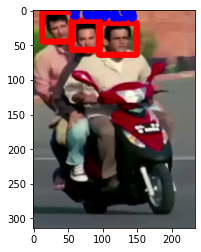

In [13]:
all_final_HNH_boxes = []
all_pred_conf_HNH = []
for i in range(len(all_instance_H_NH_boxes)):
    single_instance_boxes = all_instance_H_NH_boxes[i]
    for value in single_instance_boxes:
        temp_value = np.expand_dims(value, axis=0)
        boxes = temp_value[:, :, 0:4]
        conf = temp_value[:, :, 4:]
    all_final_HNH_boxes.append(boxes)
    all_pred_conf_HNH.append(conf)


# NMS

all_bboxes_HNH = []
all_scores_HNH = []
all_classes_HNH = []
all_num_objects_HNH = []

for i in range(len(all_final_HNH_boxes)):
    boxes = all_final_HNH_boxes[i]
    conf = all_pred_conf_HNH[i]
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(conf, (tf.shape(conf)[0], -1, tf.shape(conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=0.45,
        score_threshold=0.5
    )

    num_objects_HNH = valid_detections.numpy()[0]
    bboxes_HNH = boxes.numpy()[0]
    bboxes_HNH = bboxes_HNH[0:int(num_objects_HNH)]
    scores_HNH = scores.numpy()[0]
    scores_HNH = scores_HNH[0:int(num_objects_HNH)]
    classes_HNH = classes.numpy()[0]
    classes_HNH = classes_HNH[0:int(num_objects_HNH)]

    deleted_indx = []
    allowed_classes = [0, 1]
    for i in range(num_objects_HNH):
        class_indx = int(classes_HNH[i])
        if class_indx not in allowed_classes:
            deleted_indx.append(i)
    bboxes_HNH = np.delete(bboxes_HNH, deleted_indx, axis=0)
    scores_HNH = np.delete(scores_HNH, deleted_indx, axis=0)
    classes_HNH = np.delete(classes_HNH, deleted_indx, axis=0)
    num_objects_HNH = len(classes_HNH)

    classes_HNH[classes_HNH == 1] = 2
    classes_HNH[classes_HNH == 0] = 1

    all_bboxes_HNH.append(bboxes_HNH)
    all_scores_HNH.append(scores_HNH)
    all_classes_HNH.append(classes_HNH)
    all_num_objects_HNH.append(num_objects_HNH)

print(all_bboxes_HNH)
print(all_num_objects_HNH)
print(all_classes_HNH)
print(all_scores_HNH)
    
# show the bounding box and the label on the image
for i in range(len(roi_instances)):
    instance_frame = roi_instances[i]['frame']
    for bbox_idx in range(all_num_objects_HNH[i]):
        xmin = int(all_bboxes_HNH[i][bbox_idx][1] * frame_size_ROI[i][1])
        ymin = int(all_bboxes_HNH[i][bbox_idx][0] * frame_size_ROI[i][0])
        xmax = int(all_bboxes_HNH[i][bbox_idx][3] * frame_size_ROI[i][1])
        ymax = int(all_bboxes_HNH[i][bbox_idx][2] * frame_size_ROI[i][0])
        if all_classes_HNH[i][bbox_idx] == 1:
            cv2.rectangle(instance_frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 7)
        else :
            cv2.rectangle(instance_frame, (xmin, ymin), (xmax, ymax), (255, 0, 0), 7)
        cv2.putText(instance_frame, '{} {:.2f}'.format(int(all_classes_HNH[i][bbox_idx]), all_scores_HNH[i][bbox_idx]),
                    (xmin, ymin - 5), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 7)
    plt.imshow(instance_frame)
    plt.show()


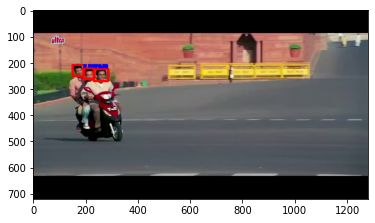

In [14]:
plt.imshow(frame)
plt.show()

In [15]:
final_bboxes_HNH = []
final_scores_HNH = []
final_classes_HNH = []
final_num_objects_HNH = 0

# convert the bounding box to the original image in yolo format and store it in final_bboxes_HNH
for i in range(len(roi_instances)):
    original_position = roi_instances[i]['original_position']
    full_frame_width = frame.shape[1]
    full_frame_height = frame.shape[0]
    for j in range(all_num_objects_HNH[i]):
        xmin = int(all_bboxes_HNH[i][j][1] * frame_size_ROI[i][1])
        ymin = int(all_bboxes_HNH[i][j][0] * frame_size_ROI[i][0])
        xmax = int(all_bboxes_HNH[i][j][3] * frame_size_ROI[i][1])
        ymax = int(all_bboxes_HNH[i][j][2] * frame_size_ROI[i][0])
        xmin = xmin + original_position[1]
        xmax = xmax + original_position[1]
        ymin = ymin + original_position[0]
        ymax = ymax + original_position[0]
        # convert to yolo format 
        x_center = (xmin + xmax) / (2 * full_frame_width)
        y_center = (ymin + ymax) / (2 * full_frame_height)
        width = (xmax - xmin) / full_frame_width
        height = (ymax - ymin) / full_frame_height
        final_bboxes_HNH.append([x_center, y_center, width, height])
        final_scores_HNH.append(all_scores_HNH[i][j])
        final_classes_HNH.append(all_classes_HNH[i][j])
        final_num_objects_HNH += 1

print(final_bboxes_HNH)
print(final_scores_HNH)
print(final_classes_HNH)
print(final_num_objects_HNH)        

[[0.202734375, 0.34305555555555556, 0.04296875, 0.06388888888888888], [0.13515625, 0.31875, 0.034375, 0.059722222222222225], [0.166796875, 0.33611111111111114, 0.03203125, 0.058333333333333334]]
[0.757116, 0.6679422, 0.5234948]
[2.0, 2.0, 2.0]
3


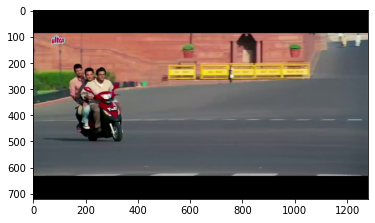

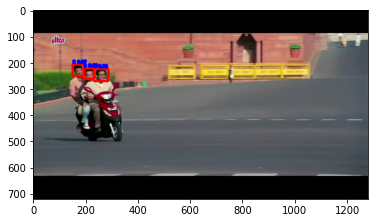

In [16]:
plt.imshow(frame2)
plt.show()

# plot final bounding box on the image
for i in range(final_num_objects_HNH):
    xmin = int((final_bboxes_HNH[i][0] - final_bboxes_HNH[i][2] / 2) * frame2.shape[1])
    ymin = int((final_bboxes_HNH[i][1] - final_bboxes_HNH[i][3] / 2) * frame2.shape[0])
    xmax = int((final_bboxes_HNH[i][0] + final_bboxes_HNH[i][2] / 2) * frame2.shape[1])
    ymax = int((final_bboxes_HNH[i][1] + final_bboxes_HNH[i][3] / 2) * frame2.shape[0])
    if final_classes_HNH[i] == 1:
        cv2.rectangle(frame2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 7)
    else :
        cv2.rectangle(frame2, (xmin, ymin), (xmax, ymax), (255, 0, 0), 7)
    cv2.putText(frame2, '{} {:.2f}'.format(int(final_classes_HNH[i]), final_scores_HNH[i]),
                (xmin, ymin - 5), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 7)
    
plt.imshow(frame2)
plt.show()

In [17]:
bboxes = np.concatenate((boxes_R_M, final_bboxes_HNH))
scores = np.concatenate((scores_R_M, final_scores_HNH))
classes = np.concatenate((classes_R_M, final_classes_HNH))
num_objects = final_num_objects_HNH + num_objects_R_M

print("CONCATENATED")
print("Classes", classes)
print("Scores", scores)
print("Bboxes", bboxes)
print("Num objects", num_objects)

CONCATENATED
Classes [3. 0. 0. 2. 2. 2.]
Scores [0.8456395 0.75094   0.6041984 0.757116  0.6679422 0.5234948]
Bboxes [[0.40205061 0.13151684 0.70324409 0.28226325]
 [0.31009793 0.16385458 0.64972371 0.25417086]
 [0.30653036 0.11679484 0.64331484 0.19953595]
 [0.20273437 0.34305556 0.04296875 0.06388889]
 [0.13515625 0.31875    0.034375   0.05972222]
 [0.16679688 0.33611111 0.03203125 0.05833333]]
Num objects 6
